In [124]:
import pandas as pd

# 5. Calcular el radio de impacto del sismo (ejemplo)
magnitud_momento = 9
profundidad = 33 

def calcular_radio_impacto(magnitud_momento, profundidad):
    # Factores de ajuste
    factor_profundidad = 10 / (profundidad + 10)
    factor_magnitud = 10 ** (0.5 * magnitud_momento - 0.6)
    
    # Ajuste no lineal para magnitudes extremas
    if magnitud_momento < 5:
        factor_magnitud *= 1.2  
    elif magnitud_momento > 8:
        factor_magnitud *= 0.6
    
    r_km = factor_magnitud * factor_profundidad
    
    return r_km

R_km = calcular_radio_impacto(magnitud_momento, profundidad)

print(R_km)


1108.3649786850438


In [125]:
print(f'R_km: {R_km} ')

R_km: 1108.3649786850438 


In [126]:

import geopandas as gpd
from shapely.geometry import shape, Point
from geopy.distance import geodesic

# 1. Cargar el archivo CSV
df = pd.read_csv('poblacion.csv', sep=';')

# 2. Crear una función para convertir GeoJSON a geometría Shapely
def convert_geojson_to_geometry(geojson_string):
    return shape(eval(geojson_string))

# 3. Aplicar la función para convertir GeoJSON a geometrías Shapely y crear un GeoDataFrame
df['geometry'] = df['Geo Shape'].apply(convert_geojson_to_geometry)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 4. Definir el epicentro del sismo (ejemplo)
epicentro_lat = -12.04318
epicentro_lon = -77.02824

epicentro = Point(epicentro_lon, epicentro_lat)


# Convertir el radio de km a grados de longitud y latitud
R_deg_lon = R_km / (111.32 * np.cos(np.radians(epicentro_lat)))  # Longitud
R_deg_lat = R_km / 110.574  # Latitud

# 6. Crear un buffer circular alrededor del epicentro del sismo
area_de_efecto = epicentro.buffer(R_deg_lon)

# 7. Intersectar el área de efecto con los distritos en el GeoDataFrame
distritos_en_area_efecto = gdf[gdf['geometry'].intersects(area_de_efecto)]

# 8. Calcular la distancia geodésica desde el epicentro a cada distrito afectado
def calcular_distancia(geometry, epicentro):
    centroide_distrito = geometry.centroid
    distancia = geodesic((epicentro.y, epicentro.x), (centroide_distrito.y, centroide_distrito.x)).kilometers
    return distancia

distritos_en_area_efecto['DISTANCIA'] = distritos_en_area_efecto['geometry'].apply(lambda geom: calcular_distancia(geom, epicentro))

/home/leon/Documentos/UNSA/IA/articulo-ia/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


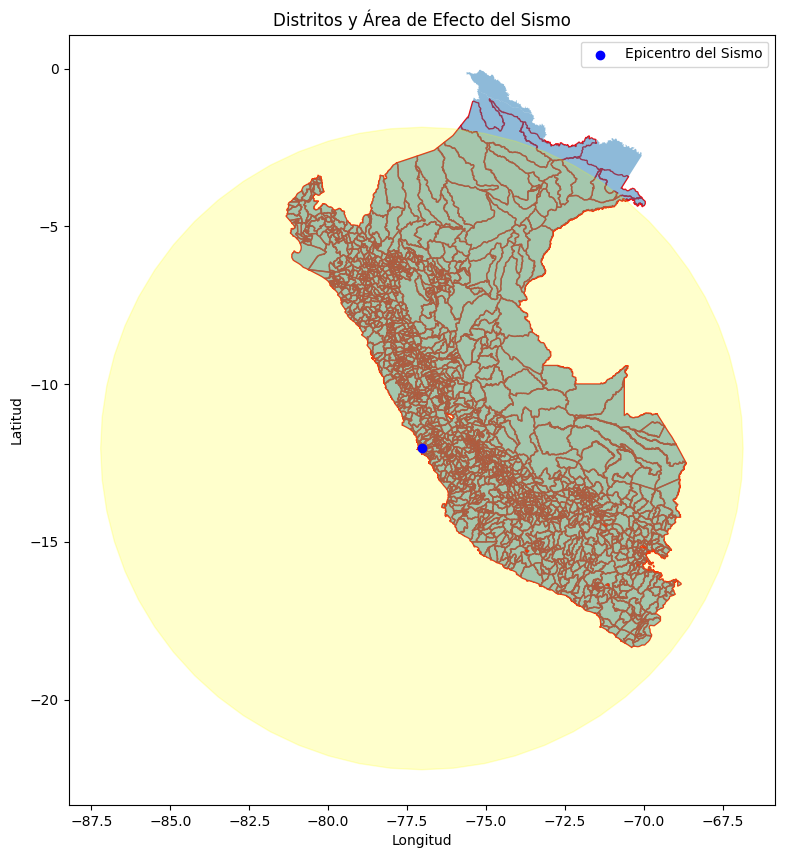

   NOMBDIST   NOMBPROV     NOMBDEP   DISTANCIA  POBLACION
0  GUZMANGO  CONTUMAZA   CAJAMARCA  557.481412     2864.0
1  SAN LUIS  SAN PABLO   CAJAMARCA  576.900029      949.0
2   LAGUNAS   CHICLAYO  LAMBAYEQUE  627.310880    10899.0
3   MONSEFU   CHICLAYO  LAMBAYEQUE  651.454555    35368.0
4   CAYALTI   CHICLAYO  LAMBAYEQUE  631.702049    16364.0


In [127]:

# 9. Visualizar el resultado
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plotear los distritos que intersectan con el área de efecto
distritos_en_area_efecto.plot(ax=ax, edgecolor='red', facecolor='none')

# Plotear todos los distritos en transparencia
gdf.plot(ax=ax, alpha=0.5)

# Plotear el área de efecto del sismo
x, y = area_de_efecto.exterior.xy
ax.fill(x, y, alpha=0.2, color='yellow')

# Plotear el epicentro del sismo
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro del Sismo', zorder=5)

# Configuración adicional del gráfico
ax.set_title('Distritos y Área de Efecto del Sismo')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()

# Guardar la figura como archivo PNG
plt.savefig('distritos_area_efecto_sismo.png', dpi=300)

# Mostrar el gráfico
plt.show()

# Mostrar las primeras filas para verificar
print(distritos_en_area_efecto[['NOMBDIST', 'NOMBPROV', 'NOMBDEP', 'DISTANCIA', 'POBLACION']].head())

In [128]:
distritos_en_area_efecto.columns

Index(['Geo Point', 'Geo Shape', 'CCDD', 'NOMBDEP', 'CCPP', 'NOMBPROV', 'CCDI',
       'NOMBDIST', 'CAPITAL', 'UBIGEO', 'IDPROV', 'CODIGO', 'CNT_CCPP',
       'DESCRIPCIO', 'POBLACION', 'FECHA', 'DAT_POB', 'geometry', 'DISTANCIA'],
      dtype='object')

In [184]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Supongamos que R_km es tu radio en kilómetros

# Definición de las variables lingüísticas
intensidad = ctrl.Antecedent(np.arange(0, 17.1, 0.1), 'intensidad')
profundidad = ctrl.Antecedent(np.arange(0, 700.1, 1), 'profundidad')
poblacion = ctrl.Antecedent(np.arange(0, 1500000.1, 1000), 'poblacion')
riesgo = ctrl.Consequent(np.arange(0, 101, 1), 'riesgo')

# Definición de los conjuntos difusos para magnitud usando función gaussiana
intensidad['baja'] = fuzz.gaussmf(intensidad.universe, 4, 0.5)
intensidad['moderada'] = fuzz.gaussmf(intensidad.universe, 8, 0.5)
intensidad['alta'] = fuzz.gaussmf(intensidad.universe, 12, 0.5)

# Definición de los conjuntos difusos para profundidad usando función trapezoidal
profundidad['superficial'] = fuzz.trapmf(profundidad.universe, [0, 20, 35, 50])
profundidad['intermedia'] = fuzz.trapmf(profundidad.universe, [40, 70, 100, 140])
profundidad['profunda'] = fuzz.trapmf(profundidad.universe, [120, 170, 250, 700])

# Definición de los conjuntos difusos para distancia
limite_cerca = [0, R_km / 10, R_km / 5]  # Rangos más pequeños para cerca
limite_media = [R_km / 6, R_km * 2 / 3, R_km]
limite_lejos = [R_km * 0.75, R_km * 1.5, R_km * 2]

distancia = ctrl.Antecedent(np.arange(0, R_km * 2 + 1, 1), 'distancia')
distancia['cerca'] = fuzz.trimf(distancia.universe, limite_cerca)
distancia['media'] = fuzz.trimf(distancia.universe, limite_media)
distancia['lejos'] = fuzz.trimf(distancia.universe, limite_lejos)

# Definición de los conjuntos difusos para población
poblacion['muy baja'] = fuzz.trimf(poblacion.universe, [0, 500, 1000])
poblacion['baja'] = fuzz.trapmf(poblacion.universe, [800, 2000, 8000, 12000])
poblacion['media'] = fuzz.trapmf(poblacion.universe, [10000, 30000, 80000, 130000])
poblacion['alta'] = fuzz.trapmf(poblacion.universe, [120000, 200000, 500000, 1500000])
poblacion['muy alta'] = fuzz.trapmf(poblacion.universe, [1000000, 1200000, 1500000, 3000000])

# Definición de los conjuntos difusos para riesgo usando función trapezoidal
riesgo['bajo'] = fuzz.trapmf(riesgo.universe, [0, 0, 20, 40])
riesgo['medio'] = fuzz.trapmf(riesgo.universe, [30, 40, 50, 70])
riesgo['alto'] = fuzz.trapmf(riesgo.universe, [60, 80, 100, 100])


[0, 110.83649786850438, 221.67299573700876] [184.7274964475073, 738.9099857900292, 1108.3649786850438] [831.2737340137828, 1662.5474680275656, 2216.7299573700875]


In [168]:
R_km

1108.3649786850438

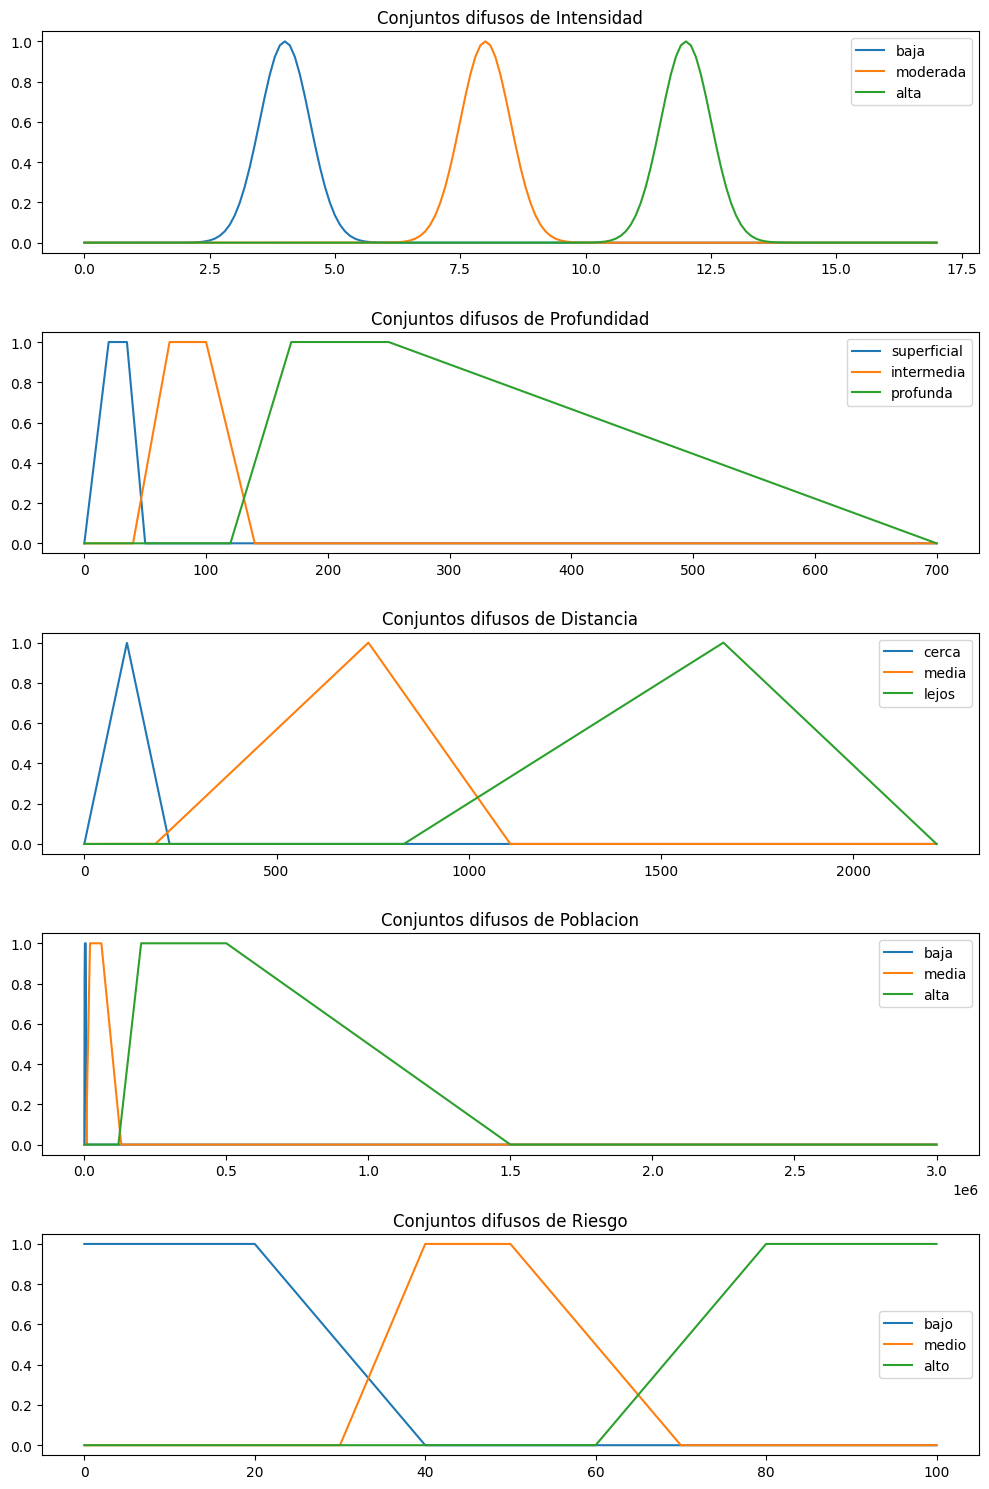

In [185]:
# Graficar los conjuntos difusos
variables = [intensidad, profundidad, distancia, poblacion, riesgo]
nombres = ['Intensidad', 'Profundidad', 'Distancia', 'Poblacion', 'Riesgo']

fig, axs = plt.subplots(len(variables), figsize=(10, 15))

for i, (variable, nombre) in enumerate(zip(variables, nombres)):
    for conjunto in variable.terms:
        axs[i].plot(variable.universe, variable[conjunto].mf, label=conjunto)
    axs[i].set_title(f'Conjuntos difusos de {nombre}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [186]:
# Definir las reglas
reglas = []

# Combinaciones de magnitud, profundidad, distancia y poblacion para definir el riesgo
combinaciones = [
    ('baja', 'superficial', 'cerca', 'baja', 'bajo'),
    ('baja', 'superficial', 'cerca', 'media', 'bajo'),
    ('baja', 'superficial', 'cerca', 'alta', 'medio'),
    ('baja', 'superficial', 'media', 'baja', 'bajo'),
    ('baja', 'superficial', 'media', 'media', 'bajo'),
    ('baja', 'superficial', 'media', 'alta', 'medio'),
    ('baja', 'superficial', 'lejos', 'baja', 'bajo'),
    ('baja', 'superficial', 'lejos', 'media', 'bajo'),
    ('baja', 'superficial', 'lejos', 'alta', 'bajo'),

    ('baja', 'intermedia', 'cerca', 'baja', 'bajo'),
    ('baja', 'intermedia', 'cerca', 'media', 'bajo'),
    ('baja', 'intermedia', 'cerca', 'alta', 'medio'),
    ('baja', 'intermedia', 'media', 'baja', 'bajo'),
    ('baja', 'intermedia', 'media', 'media', 'bajo'),
    ('baja', 'intermedia', 'media', 'alta', 'medio'),
    ('baja', 'intermedia', 'lejos', 'baja', 'bajo'),
    ('baja', 'intermedia', 'lejos', 'media', 'bajo'),
    ('baja', 'intermedia', 'lejos', 'alta', 'bajo'),

    ('baja', 'profunda', 'cerca', 'baja', 'bajo'),
    ('baja', 'profunda', 'cerca', 'media', 'bajo'),
    ('baja', 'profunda', 'cerca', 'alta', 'medio'),
    ('baja', 'profunda', 'media', 'baja', 'bajo'),
    ('baja', 'profunda', 'media', 'media', 'bajo'),
    ('baja', 'profunda', 'media', 'alta', 'medio'),
    ('baja', 'profunda', 'lejos', 'baja', 'bajo'),
    ('baja', 'profunda', 'lejos', 'media', 'bajo'),
    ('baja', 'profunda', 'lejos', 'alta', 'bajo'),

    ('moderada', 'superficial', 'cerca', 'baja', 'medio'),
    ('moderada', 'superficial', 'cerca', 'media', 'medio'),
    ('moderada', 'superficial', 'cerca', 'alta', 'alto'),
    ('moderada', 'superficial', 'media', 'baja', 'medio'),
    ('moderada', 'superficial', 'media', 'media', 'medio'),
    ('moderada', 'superficial', 'media', 'alta', 'alto'),
    ('moderada', 'superficial', 'lejos', 'baja', 'medio'),
    ('moderada', 'superficial', 'lejos', 'media', 'medio'),
    ('moderada', 'superficial', 'lejos', 'alta', 'medio'),

    ('moderada', 'intermedia', 'cerca', 'baja', 'medio'),
    ('moderada', 'intermedia', 'cerca', 'media', 'medio'),
    ('moderada', 'intermedia', 'cerca', 'alta', 'alto'),
    ('moderada', 'intermedia', 'media', 'baja', 'medio'),
    ('moderada', 'intermedia', 'media', 'media', 'medio'),
    ('moderada', 'intermedia', 'media', 'alta', 'alto'),
    ('moderada', 'intermedia', 'lejos', 'baja', 'medio'),
    ('moderada', 'intermedia', 'lejos', 'media', 'medio'),
    ('moderada', 'intermedia', 'lejos', 'alta', 'medio'),

    ('moderada', 'profunda', 'cerca', 'baja', 'medio'),
    ('moderada', 'profunda', 'cerca', 'media', 'medio'),
    ('moderada', 'profunda', 'cerca', 'alta', 'alto'),
    ('moderada', 'profunda', 'media', 'baja', 'medio'),
    ('moderada', 'profunda', 'media', 'media', 'medio'),
    ('moderada', 'profunda', 'media', 'alta', 'alto'),
    ('moderada', 'profunda', 'lejos', 'baja', 'medio'),
    ('moderada', 'profunda', 'lejos', 'media', 'medio'),
    ('moderada', 'profunda', 'lejos', 'alta', 'medio'),

    ('alta', 'superficial', 'cerca', 'baja', 'alto'),
    ('alta', 'superficial', 'cerca', 'media', 'alto'),
    ('alta', 'superficial', 'cerca', 'alta', 'alto'),
    ('alta', 'superficial', 'media', 'baja', 'alto'),
    ('alta', 'superficial', 'media', 'media', 'alto'),
    ('alta', 'superficial', 'media', 'alta', 'alto'),
    ('alta', 'superficial', 'lejos', 'baja', 'alto'),
    ('alta', 'superficial', 'lejos', 'media', 'alto'),
    ('alta', 'superficial', 'lejos', 'alta', 'alto'),

    ('alta', 'intermedia', 'cerca', 'baja', 'alto'),
    ('alta', 'intermedia', 'cerca', 'media', 'alto'),
    ('alta', 'intermedia', 'cerca', 'alta', 'alto'),
    ('alta', 'intermedia', 'media', 'baja', 'alto'),
    ('alta', 'intermedia', 'media', 'media', 'alto'),
    ('alta', 'intermedia', 'media', 'alta', 'alto'),
    ('alta', 'intermedia', 'lejos', 'baja', 'alto'),
    ('alta', 'intermedia', 'lejos', 'media', 'alto'),
    ('alta', 'intermedia', 'lejos', 'alta', 'alto'),

    ('alta', 'profunda', 'cerca', 'baja', 'alto'),
    ('alta', 'profunda', 'cerca', 'media', 'alto'),
    ('alta', 'profunda', 'cerca', 'alta', 'alto'),
    ('alta', 'profunda', 'media', 'baja', 'alto'),
    ('alta', 'profunda', 'media', 'media', 'alto'),
    ('alta', 'profunda', 'media', 'alta', 'alto'),
    ('alta', 'profunda', 'lejos', 'baja', 'alto'),
    ('alta', 'profunda', 'lejos', 'media', 'alto'),
    ('alta', 'profunda', 'lejos', 'alta', 'alto')
]


for magn, prof, dist, pobl, rieg in combinaciones:
    reglas.append(ctrl.Rule(intensidad[magn] & profundidad[prof] & distancia[dist] & poblacion[pobl], riesgo[rieg]))

# Crear el sistema de control difuso
control_riesgo = ctrl.ControlSystem(reglas)
simulacion_riesgo = ctrl.ControlSystemSimulation(control_riesgo)


In [187]:
def calcular_intensidad(distancia, magnitud):
    return 1.7*magnitud -4.82*np.log10(distancia) + 3.97

# Supongamos que la magnitud del terremoto está almacenada en una variable 'magnitud'

# Aplicar la fórmula a cada fila de la columna 'Distancia al Epicentro (km)', pasando la magnitud como un argumento adicional
distritos_en_area_efecto['INTENSIDAD'] = distritos_en_area_efecto['DISTANCIA'].apply(lambda x: calcular_intensidad(x, magnitud_momento))


In [188]:

# Inicializar una lista para almacenar los resultados de riesgo
resultados_riesgo = []
# Iterar sobre cada fila del DataFrame y calcular el riesgo
for index, row in distritos_en_area_efecto.iterrows():
    simulacion_riesgo.input['intensidad'] = row['INTENSIDAD']  # Puedes ajustar estos valores según tu caso
    simulacion_riesgo.input['profundidad'] = 33  # Puedes ajustar estos valores según tu caso
    simulacion_riesgo.input['distancia'] = row['DISTANCIA']
    simulacion_riesgo.input['poblacion'] = row['POBLACION']
    
    # Computar el resultado
    simulacion_riesgo.compute()
    
    # Obtener el resultado
    resultado_riesgo = simulacion_riesgo.output['riesgo']
    
    # Agregar el resultado a la lista
    resultados_riesgo.append(resultado_riesgo)

# Agregar los resultados al DataFrame original
distritos_en_area_efecto['RIESGO'] = resultados_riesgo


In [189]:

# Mostrar el DataFrame con los resultados de riesgo
distritos_en_area_efecto[['NOMBDIST' , 'NOMBPROV' ,'POBLACION','RIESGO', 'DISTANCIA' , 'INTENSIDAD']].head()

,NOMBDIST,NOMBPROV,POBLACION,RIESGO,DISTANCIA,INTENSIDAD
0,GUZMANGO,CONTUMAZA,2864.0,39.323074,557.481412,6.033170
1,SAN LUIS,SAN PABLO,949.0,30.077338,576.900029,5.961495
2,LAGUNAS,CHICLAYO,10899.0,20.832327,627.310880,5.786133
3,MONSEFU,CHICLAYO,35368.0,20.230956,651.454555,5.707079
4,CAYALTI,CHICLAYO,16364.0,20.667600,631.702049,5.771531


In [190]:
distritos_csv = distritos_en_area_efecto[['NOMBDIST' , 'NOMBPROV' , 'NOMBDEP', 'POBLACION' , 'INTENSIDAD' , 'DISTANCIA' ,'RIESGO']]
distritos_csv.to_csv('riesgo.csv')

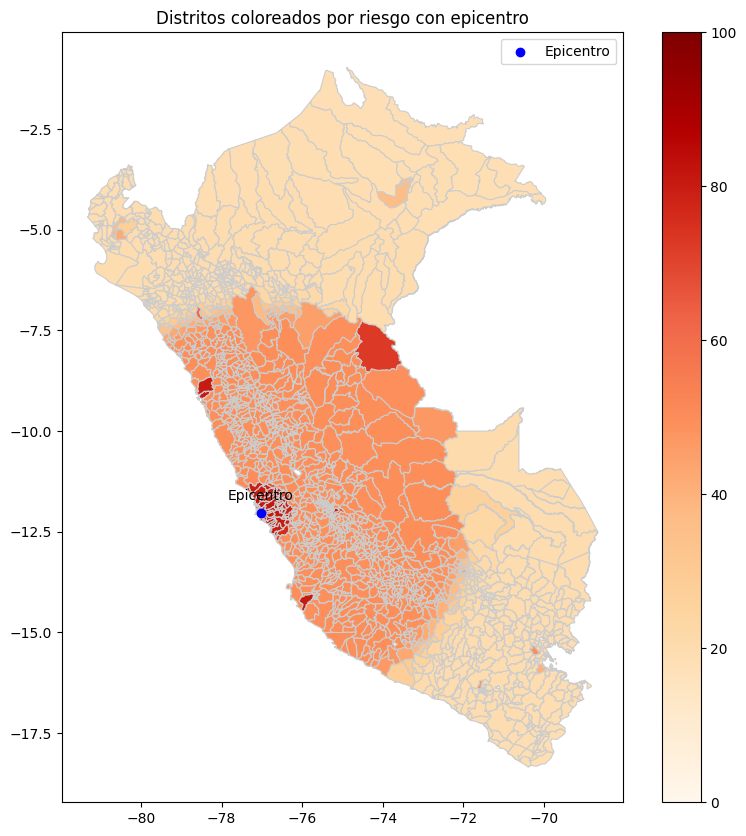

In [191]:
import geopandas as gpd
from matplotlib.colors import Normalize
distritos_en_area_efecto['geometry'] = distritos_en_area_efecto['Geo Shape'].apply(convert_geojson_to_geometry)

gdf = gpd.GeoDataFrame(distritos_en_area_efecto, geometry='geometry')

# Configurar la escala de color con un límite máximo de 100
norm = Normalize(vmin=0, vmax=100)

# Graficar los distritos y colorearlos según el riesgo
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='RIESGO', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, norm=norm)

# Graficar el epicentro
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro', zorder=5)
ax.annotate('Epicentro', (epicentro_lon, epicentro_lat), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Distritos coloreados por riesgo con epicentro')
plt.legend()
plt.show()